## Importações

<h4>Bibliotecas que foram utilizadas durante o desenvolvimento do código e seus objetivos:</h4>

- Sklearn : 
    
    Para avaliar o desempenho dos modelos utilizando a técnica do Cross Validation (model_selection)

    Encontrar o melhor conjunto de parametros para o modelo de acordo com as informações apresentadas (model_selection)

    Para captar os modelos (naive_bayes, neighbors)

- Pandas :
    
    Disponibiliza ferramentas para manipular DataFrames, como por exemplo a forma que são apresentadas as bases

- Pickle:
    
    É usado para extrair as bases do arquivo "bases.pk1" e para armazenar o modelo escolhido em um arquivo .pk1

- Numpy

    No contexto deste notebook, ele auxilia nos intervalos de números que são apresentados nos parametros dos modelos.

In [6]:
# Pandas
import pandas as pd

# Pickle
import pickle

# Numpy
import numpy as np

# Sklearn
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

import math
from scipy.stats import norm
import time

# Analisando Desempenho de Modelos

## Teste de desempenho entre os modelos e as bases

### Seleção das Bases

In [7]:
# Extraindo as bases de dados limpas que foram armazenadas no arquivo .pk1
bases_armazenadas = pickle.load(open('./bases/bases.pk1','rb'))

# Criando dicionarios para armazenar os dados separados de cada base disponivel
# Para todos os valores de treino
values_train = {}

# Para todos os valores de teste
values_test = {}

# Realizando a separação de cada base nas divisões que cada dicionario representa
for key, value in bases_armazenadas.items():
    atributo = value.iloc[:, :-1]
    resposta = value.iloc[:, -1]

    # Divisão que separa a base inteira em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(atributo, resposta, test_size=0.2, random_state=42)
    values_train[key] = [X_train, y_train]
    values_test[key] = [X_test, y_test]

display(X_train.head(1))

,cidade,compra_roupa_usada,dificuldade_compra,dificuldade_infantil,faixa_etaria,faixa_etaria_filho,faixa_salarial,flag_filho,forma_trocou,genero,objetivo_compra,reciclagem_tecido,seguranca_aplicativo
266,19.0,0.0,4.764094,4.764094,6.0,14.0,2.235906,0.0,0.707718,1.0,0.235906,0.0,0.764094


### Seleção dos modelos

In [8]:
modelos = {}

# Naive Bayes
modelos['naive_bayes'] = [
    GaussianNB(),
    {
        'var_smoothing': np.logspace(0,-9, num=100)
    }]

# Arvore - Tree
modelos['tree'] = [
    tree.DecisionTreeClassifier(),
    {
        'criterion' : ['gini', 'entropy'],
        'splitter' : ['best', 'random'],
        'max_depth' : [None, 2, 4, 6, 8, 10, 12],
        'min_samples_split' : [2, 5, 10],
        'min_samples_leaf' : [2, 5, 10],
        'max_features' : [None, 'sqrt', 'log2']
    }]

# KNN 
modelos['knn'] = [
    KNeighborsClassifier(),
    {
    'n_neighbors' : np.arange(3, 15),
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'kd_tree'],
    'leaf_size' : np.arange(10, 30, 5),
    'p' : [1, 2, 3],
    'metric' : ['minkowski', 'manhattan'],
    'n_jobs' : [1, -1]
    }]

### Encontrando as melhores combinações

In [9]:
infos = {}

for i in modelos.keys():
    grid = GridSearchCV(estimator=modelos[i][0], param_grid=modelos[i][1], scoring='f1', cv=5)

    for x in values_train.keys():
        grid.fit(values_train[x][0], values_train[x][1])
        chave = x+'_'+i
        resultados = grid.cv_results_
        best_index = grid.best_index_

        infos[chave] = {
            'Modelo' : grid.best_estimator_,   
            'Parametros' : grid.best_params_,
            'DesvioPadrao' : resultados['std_test_score'][best_index],
            'F1s' : [resultados[f'split{i}_test_score'][best_index] for i in range(grid.cv)],
            'MediaF1' : resultados['mean_test_score'][best_index]
            }

### Gráfico de desempenho das bases

In [10]:
x_naive = []
x_tree = []
x_knn = []

for i in infos.keys():
    if 'naive_bayes' in i:
        x_naive.append(i)
    elif 'tree' in i:
        x_tree.append(i)
    elif 'knn' in i:
        x_knn.append(i)

##### Naive Bayes

In [11]:
fig_bayes = go.Figure()

y = [infos[i]['MediaF1'] for i in x_naive]

y_formatted = [round(value, 3) for value in y]

fig_bayes.add_bar(x=x_naive, y=y, text=y_formatted, textposition='auto', textangle=-360)

fig_bayes.update_layout(
    title='Performace das bases com o Naive Bayes',
    xaxis_title='Bases',
    yaxis_title='F1 Score'
)

fig_bayes.show()

##### Tree

In [12]:
fig_tree = go.Figure()

y = [infos[i]['MediaF1'] for i in x_tree]

y_formatted = [round(value, 3) for value in y]

fig_tree.add_bar(x=x_tree, y=y, text=y_formatted, textposition='auto', textangle=-360)

fig_tree.update_layout(
    title='Performace das bases com a Tree',
    xaxis_title='Bases',
    yaxis_title='F1 Score'
)

fig_tree.show()

##### KNN

In [13]:
fig_knn = go.Figure()

y = [infos[i]['MediaF1'] for i in x_knn]

y_formatted = [round(value, 3) for value in y]

fig_knn.add_bar(x=x_knn, y=y, text=y_formatted, textposition='auto', textangle=-360)

fig_knn.update_layout(
    title='Performace das bases com a KNN',
    xaxis_title='Bases',
    yaxis_title='F1 Score'
)

fig_knn.show()

## Guardando os melhores modelos

In [14]:
melhor_f1_naive = 0
melhor_f1_tree = 0
melhor_f1_knn = 0
melhores_modelos = {}

for i in infos.keys():
    f1 = infos[i]['MediaF1']
    if f1 <= 0.97:
        if 'naive_bayes' in i:
            if f1 > melhor_f1_naive:
                melhor_f1_naive = f1
                melhores_modelos['naive_bayes'] = [infos[i], i]
        elif 'tree' in i:
            if f1 > melhor_f1_tree:
                melhor_f1_tree = f1
                melhores_modelos['tree'] = [infos[i], i]
        elif 'knn' in i:
            if f1 > melhor_f1_knn:
                melhor_f1_knn = f1
                melhores_modelos['knn'] = [infos[i], i]
    else:
        continue

In [15]:
print(infos['df_bootstrap_knn']['MediaF1'])

0.9975609453814528


In [16]:
print(melhores_modelos)

{'naive_bayes': [{'Modelo': GaussianNB(var_smoothing=0.01873817422860384), 'Parametros': {'var_smoothing': 0.01873817422860384}, 'DesvioPadrao': 0.002266020639152498, 'F1s': [0.8601398601398601, 0.8601398601398601, 0.861646234676007, 0.8631578947368421, 0.8661971830985915], 'MediaF1': 0.8622562065582322}, 'df_bootstrap_naive_bayes'], 'tree': [{'Modelo': DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2,
                       min_samples_split=5), 'Parametros': {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}, 'DesvioPadrao': 0.01090565978016599, 'F1s': [0.9177215189873418, 0.9296636085626911, 0.9272727272727272, 0.9090909090909091, 0.9411764705882353], 'MediaF1': 0.9249850469003809}, 'df_svm_smote_tree'], 'knn': [{'Modelo': KNeighborsClassifier(leaf_size=10, n_jobs=1, n_neighbors=4, p=1,
                     weights='distance'), 'Parametros': {'algorithm': 'auto', 'leaf_size': 10, 'metric'

In [17]:
for i in melhores_modelos.keys():
    nomes_sep = melhores_modelos[i][1].split('_')
    nome_base = [nomes_sep[i] for i in range(0, len(nomes_sep)-1)]
    nome_base_final = ''

    for x in range(0, len(nome_base)):
        if nome_base[x] == 'naive':
            nome_base_final = nome_base_final[:-1]
            continue
        elif x == len(nome_base)-1:
            nome_base_final = nome_base_final + nome_base[x]
        else:
            nome_base_final += nome_base[x]+'_'
    
    melhores_modelos[i][1] = nome_base_final
    melhores_modelos[i].append(values_train[nome_base_final])
    melhores_modelos[i].append(values_test[nome_base_final])
    melhores_modelos[i].append(bases_armazenadas[nome_base_final])

In [18]:
pickle.dump(
    melhores_modelos, 
    open('./modelos_before.pk1', 'wb'))

# Validação dos Modelos

## Modelo Naive Bayes

### Treino e teste

Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       0.77      1.00      0.87       314

    accuracy                           0.77       408
   macro avg       0.38      0.50      0.43       408
weighted avg       0.59      0.77      0.67       408

[[  0  94]
 [  0 314]]


C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



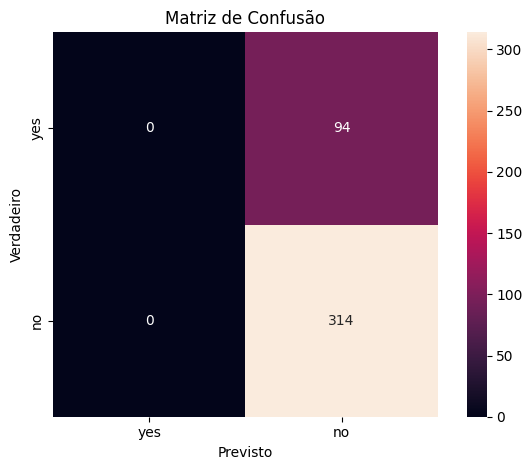

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       0.77      1.00      0.87       314

    accuracy                           0.77       408
   macro avg       0.38      0.50      0.43       408
weighted avg       0.59      0.77      0.67       408

[[  0  94]
 [  0 314]]


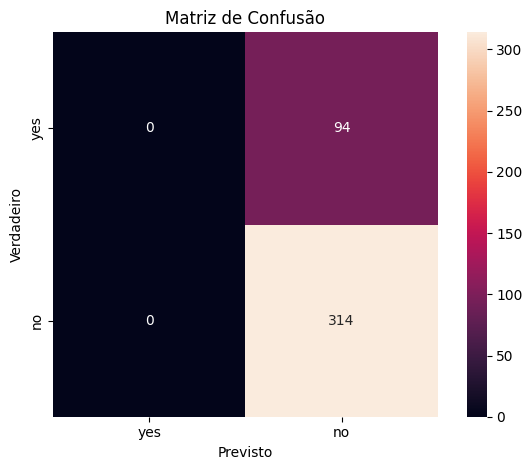

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       0.77      1.00      0.87       314

    accuracy                           0.77       408
   macro avg       0.38      0.50      0.43       408
weighted avg       0.59      0.77      0.67       408

[[  0  94]
 [  0 314]]


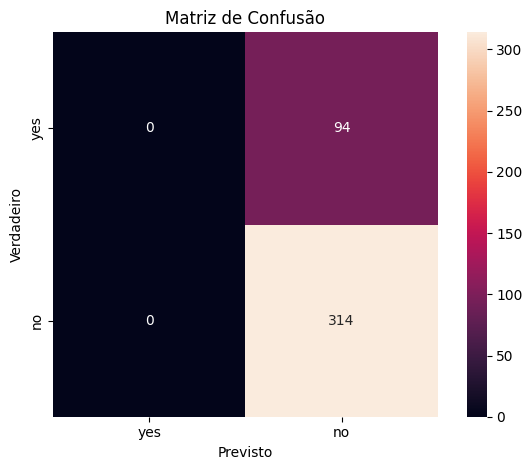

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       0.77      1.00      0.87       314

    accuracy                           0.77       408
   macro avg       0.38      0.50      0.43       408
weighted avg       0.59      0.77      0.67       408

[[  0  94]
 [  0 314]]


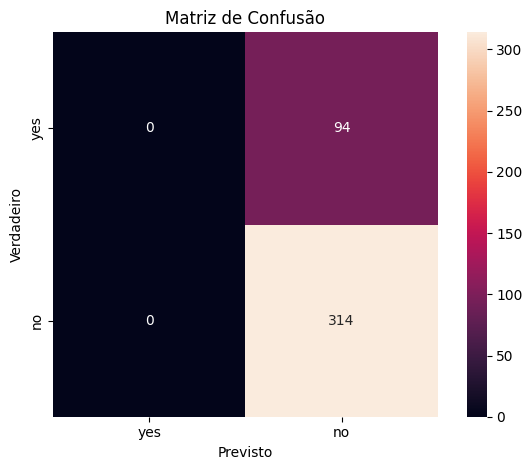

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       0.77      1.00      0.87       314

    accuracy                           0.77       408
   macro avg       0.38      0.50      0.43       408
weighted avg       0.59      0.77      0.67       408

[[  0  94]
 [  0 314]]


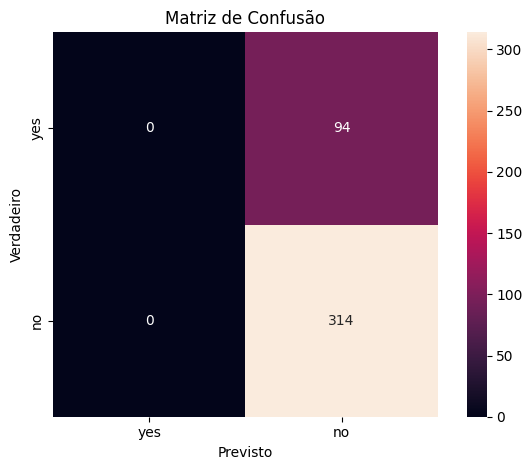

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sarahbatista-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       0.77      1.00      0.87       314

    accuracy                           0.77       408
   macro avg       0.38      0.50      0.43       408
weighted avg       0.59      0.77      0.67       408

[[  0  94]
 [  0 314]]


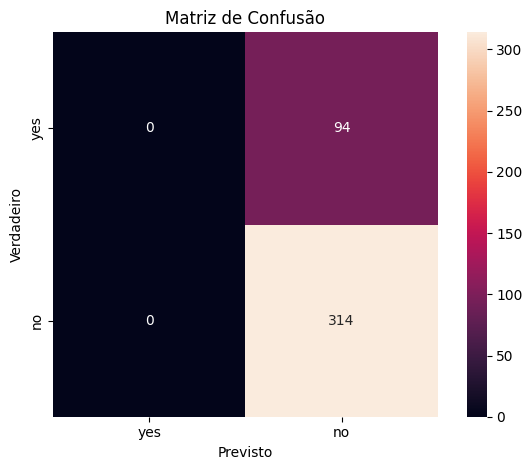

[0.013679299998329952, 0.017138899987912737, 0.005747000002884306, 0.009222599997883663, 0.007608600004459731, 0.00981119999778457]


In [19]:
tempo_naive = []

for i in range(0, 6):
    inicio = time.perf_counter()

    melhor_naive = melhores_modelos['naive_bayes'][0]['Modelo']
    melhor_naive.fit(melhores_modelos['naive_bayes'][2][0], melhores_modelos['naive_bayes'][2][1])

    y_pred_naive = melhor_naive.predict(melhores_modelos['naive_bayes'][3][0])
    y_test_naive = melhores_modelos['naive_bayes'][3][1]

    fim = time.perf_counter()

    tempo_naive.append(fim - inicio)

    print("Reporte das Métricas que foram testadas:\n", classification_report(y_test_naive, y_pred_naive))

    matriz_de_confusao = confusion_matrix(y_test_naive, y_pred_naive)
    print(matriz_de_confusao)

    sns.heatmap(matriz_de_confusao, square=True, annot=True, fmt='d', cbar=True,
                yticklabels=['yes','no'],
                xticklabels=['yes','no'])
    plt.title('Matriz de Confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.tight_layout()
    plt.show()
print(tempo_naive)

## Modelo Tree

#### Treino e validação

Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87       132
           1       0.89      0.94      0.91       188

    accuracy                           0.90       320
   macro avg       0.90      0.89      0.89       320
weighted avg       0.90      0.90      0.90       320

[[111  21]
 [ 12 176]]


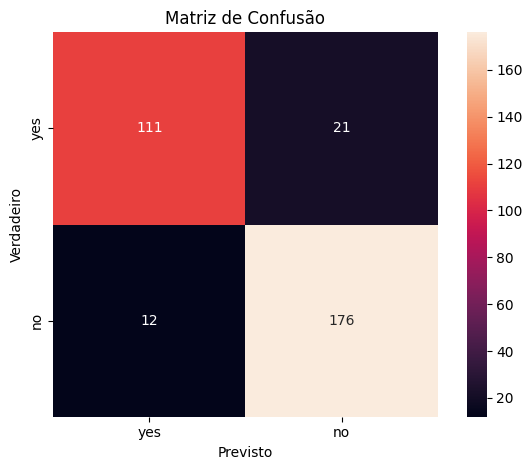

Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.88      0.83      0.85       132
           1       0.88      0.92      0.90       188

    accuracy                           0.88       320
   macro avg       0.88      0.87      0.88       320
weighted avg       0.88      0.88      0.88       320

[[109  23]
 [ 15 173]]


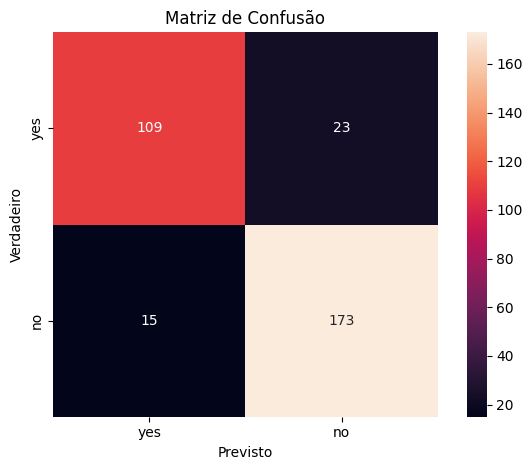

Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87       132
           1       0.90      0.93      0.91       188

    accuracy                           0.90       320
   macro avg       0.90      0.89      0.89       320
weighted avg       0.90      0.90      0.90       320

[[113  19]
 [ 14 174]]


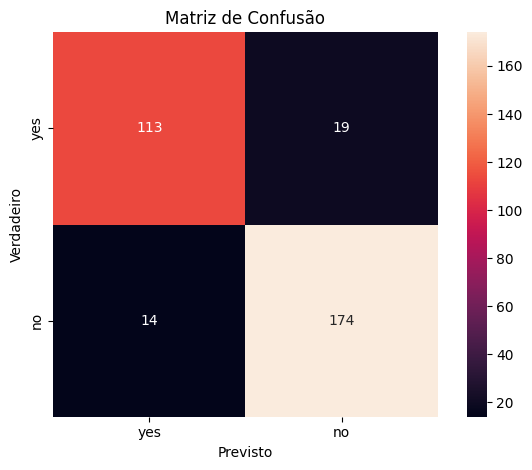

Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86       132
           1       0.90      0.91      0.91       188

    accuracy                           0.89       320
   macro avg       0.89      0.88      0.88       320
weighted avg       0.89      0.89      0.89       320

[[112  20]
 [ 16 172]]


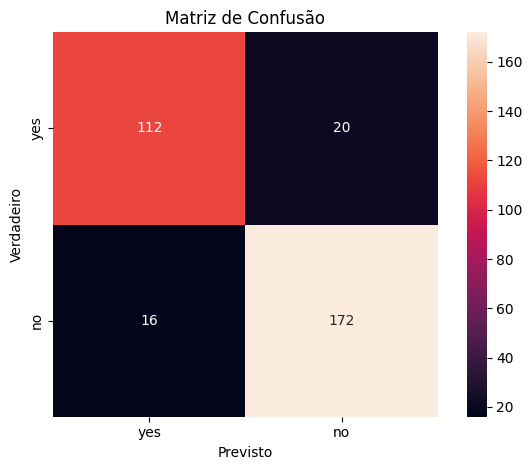

Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87       132
           1       0.89      0.94      0.91       188

    accuracy                           0.90       320
   macro avg       0.90      0.89      0.89       320
weighted avg       0.90      0.90      0.90       320

[[111  21]
 [ 12 176]]


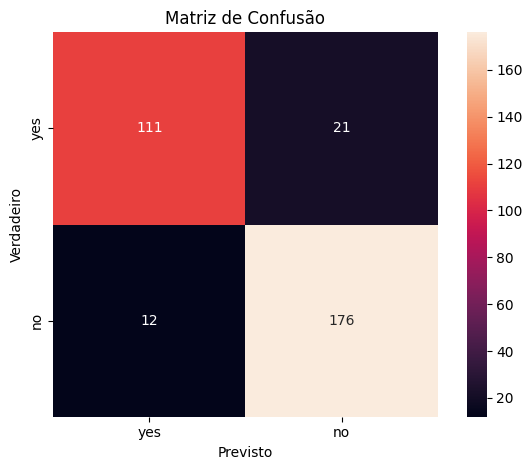

Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.88      0.83      0.85       132
           1       0.88      0.92      0.90       188

    accuracy                           0.88       320
   macro avg       0.88      0.87      0.88       320
weighted avg       0.88      0.88      0.88       320

[[109  23]
 [ 15 173]]


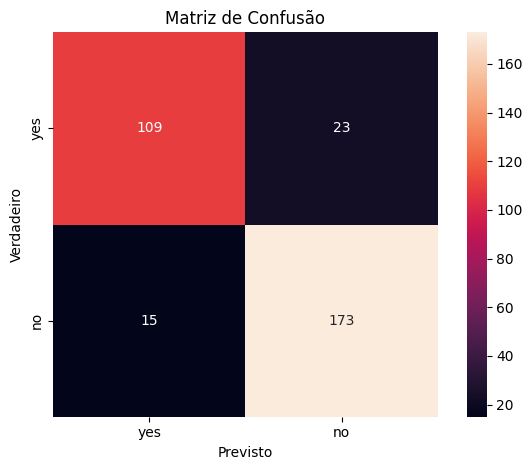

[0.049670699998387136, 0.0419267000106629, 0.030880300007993355, 0.018414400008623488, 0.02351759999874048, 0.03385970000817906]


In [20]:
tempo_tree = []

for i in range(0, 6):
    inicio = time.perf_counter()

    melhor_tree = melhores_modelos['tree'][0]['Modelo']
    melhor_tree.fit(melhores_modelos['tree'][2][0], melhores_modelos['tree'][2][1])

    y_pred_tree = melhor_tree.predict(melhores_modelos['tree'][3][0])
    y_test_tree = melhores_modelos['tree'][3][1]

    fim = time.perf_counter()

    tempo_tree.append(fim - inicio)

    # Metricas
    print("Reporte das Métricas que foram testadas:\n", classification_report(y_test_tree, y_pred_tree))

    matriz_de_confusao = confusion_matrix(y_test_tree, y_pred_tree)
    print(matriz_de_confusao)

    sns.heatmap(matriz_de_confusao, square=True, annot=True, fmt='d', cbar=True,
                yticklabels=['yes','no'],
                xticklabels=['yes','no'])
    plt.title('Matriz de Confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.tight_layout()
    plt.show()
print(tempo_tree)

## Modelo Knn

### Treino e Validação

Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       203
           1       0.99      0.97      0.98       205

    accuracy                           0.98       408
   macro avg       0.98      0.98      0.98       408
weighted avg       0.98      0.98      0.98       408

[[201   2]
 [  7 198]]


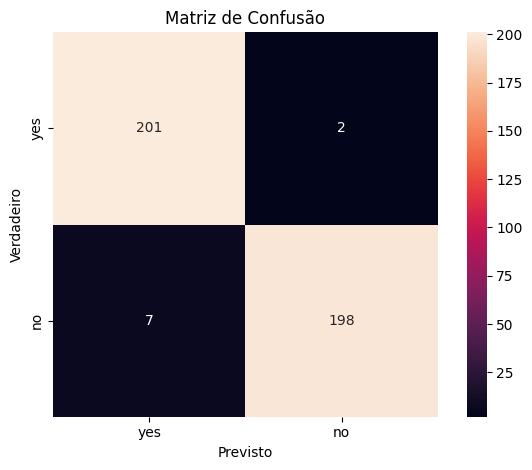

Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       203
           1       0.99      0.97      0.98       205

    accuracy                           0.98       408
   macro avg       0.98      0.98      0.98       408
weighted avg       0.98      0.98      0.98       408

[[201   2]
 [  7 198]]


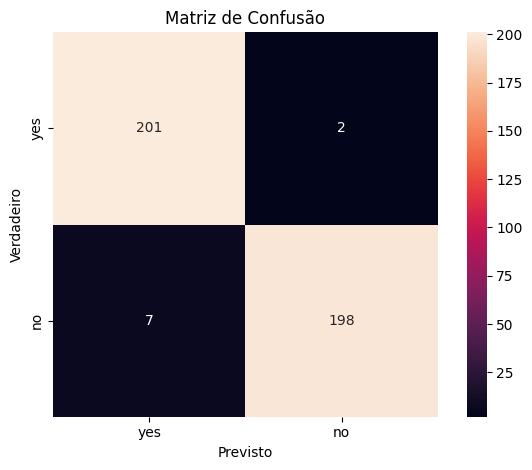

Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       203
           1       0.99      0.97      0.98       205

    accuracy                           0.98       408
   macro avg       0.98      0.98      0.98       408
weighted avg       0.98      0.98      0.98       408

[[201   2]
 [  7 198]]


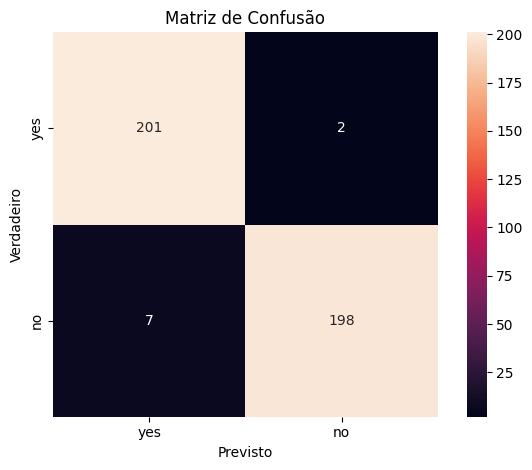

Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       203
           1       0.99      0.97      0.98       205

    accuracy                           0.98       408
   macro avg       0.98      0.98      0.98       408
weighted avg       0.98      0.98      0.98       408

[[201   2]
 [  7 198]]


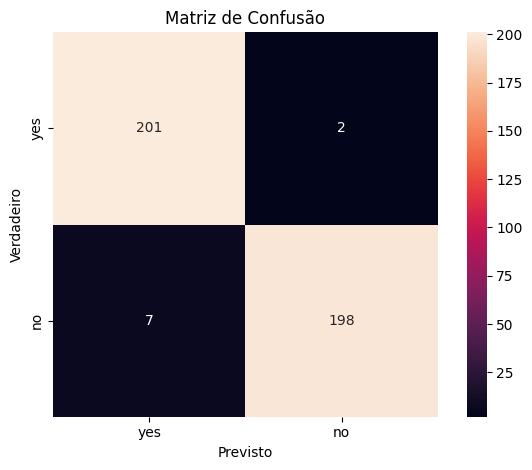

Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       203
           1       0.99      0.97      0.98       205

    accuracy                           0.98       408
   macro avg       0.98      0.98      0.98       408
weighted avg       0.98      0.98      0.98       408

[[201   2]
 [  7 198]]


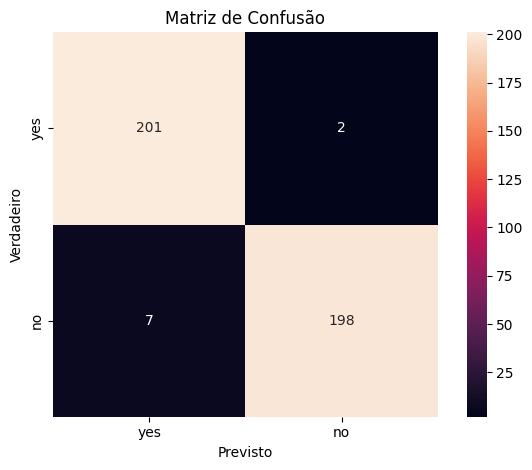

Reporte das Métricas que foram testadas:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       203
           1       0.99      0.97      0.98       205

    accuracy                           0.98       408
   macro avg       0.98      0.98      0.98       408
weighted avg       0.98      0.98      0.98       408

[[201   2]
 [  7 198]]


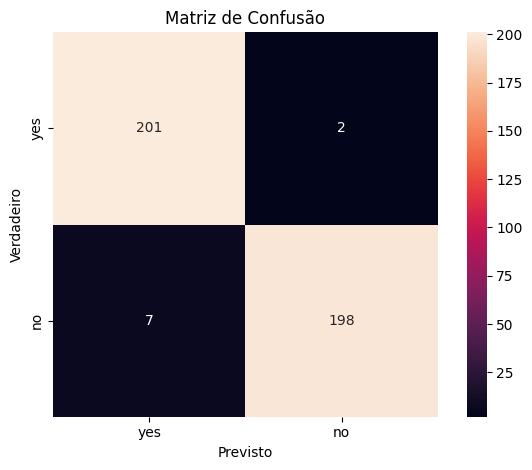

[0.05935929999395739, 0.045340999990003183, 0.025433500006329268, 0.034948200001963414, 0.03216400000383146, 0.039388000004692]


In [21]:
tempo_knn = []
for i in range(0, 6):
    inicio = time.perf_counter()

    melhor_knn = melhores_modelos['knn'][0]['Modelo']
    melhor_knn.fit(melhores_modelos['knn'][2][0], melhores_modelos['knn'][2][1])

    y_pred_knn = melhor_knn.predict(melhores_modelos['knn'][3][0])
    y_test_knn = melhores_modelos['knn'][3][1]

    fim = time.perf_counter()

    tempo_knn.append(fim - inicio)

    #Metricas
    print("Reporte das Métricas que foram testadas:\n", classification_report(y_test_knn, y_pred_knn))

    matriz_de_confusao = confusion_matrix(y_test_knn, y_pred_knn)
    print(matriz_de_confusao)

    sns.heatmap(matriz_de_confusao, square=True, annot=True, fmt='d', cbar=True,
                yticklabels=['yes','no'],
                xticklabels=['yes','no'])
    plt.title('Matriz de Confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.tight_layout()
    plt.show()
print(tempo_knn)

# Matriz de correlação

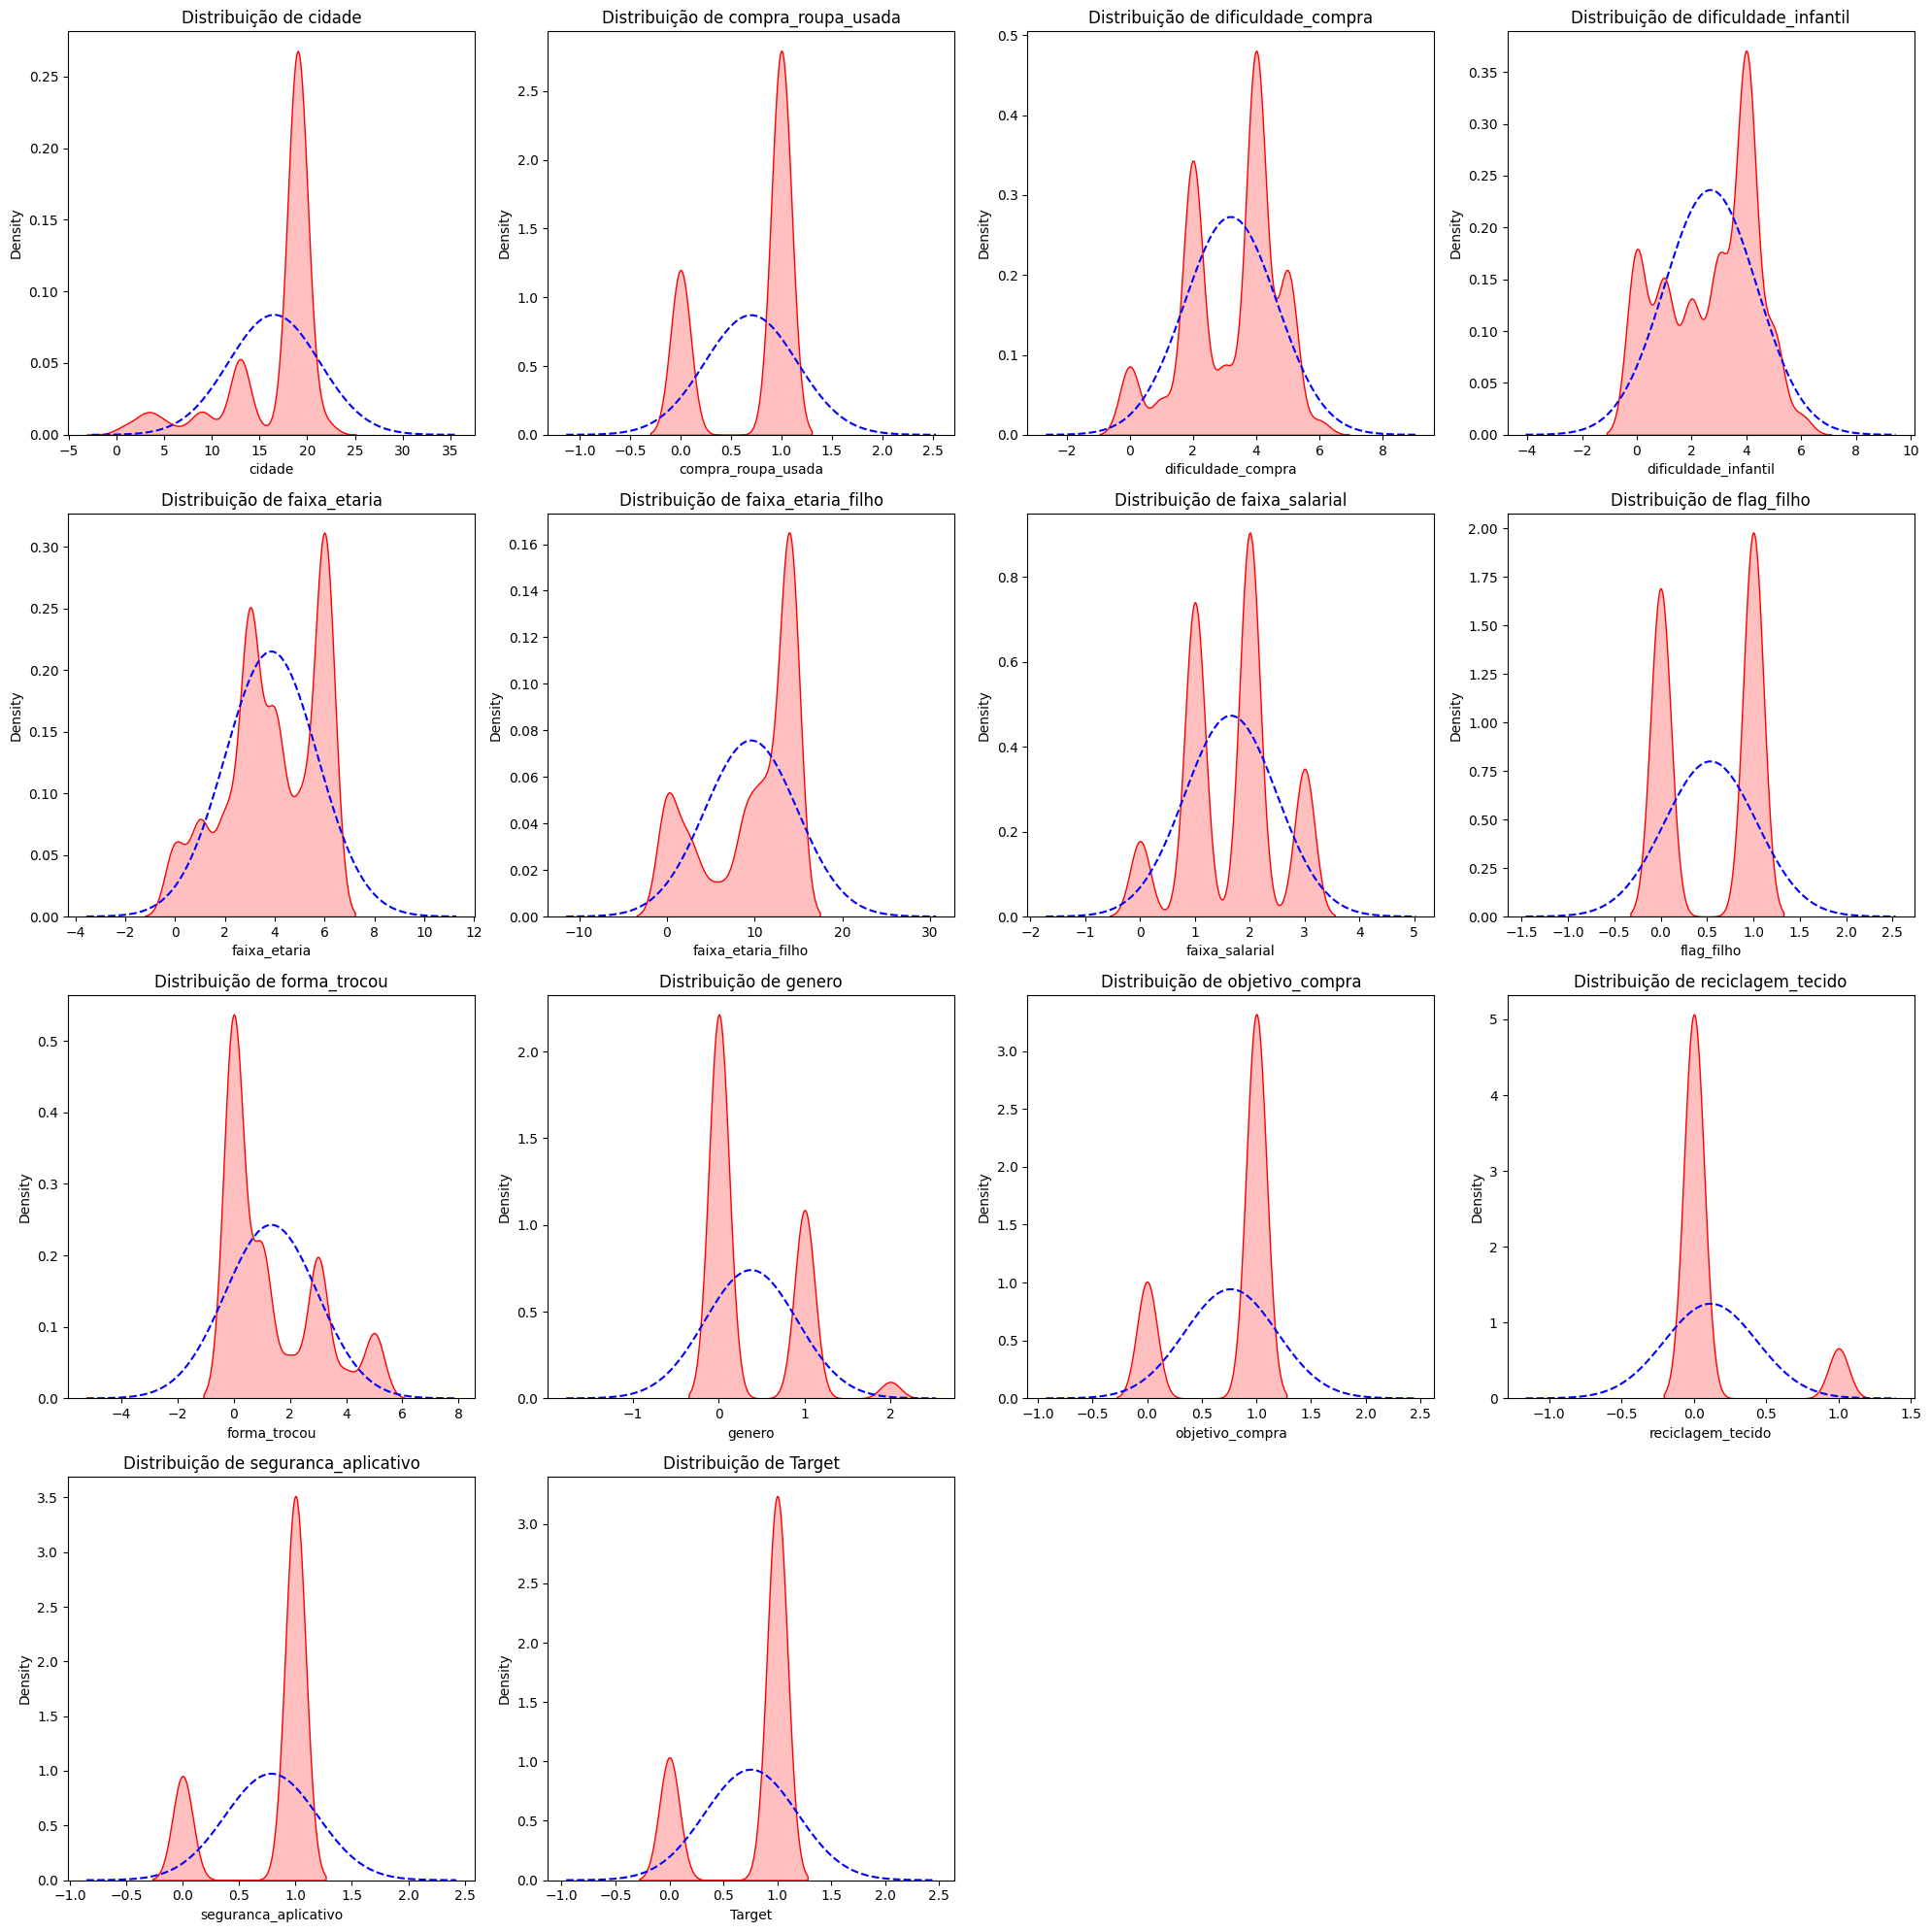

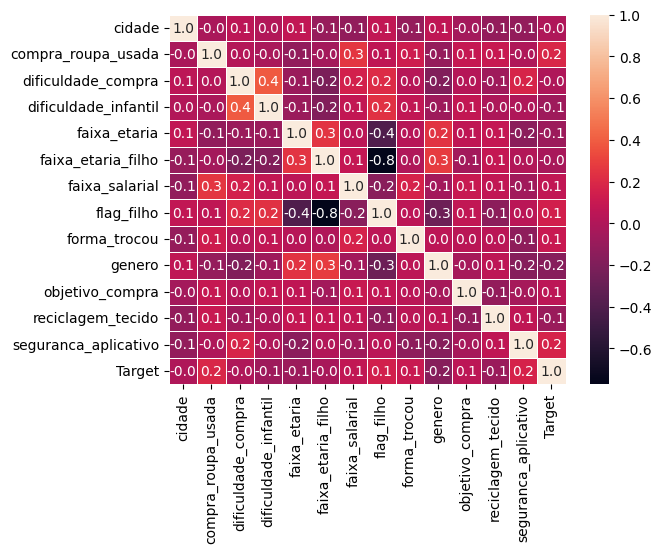

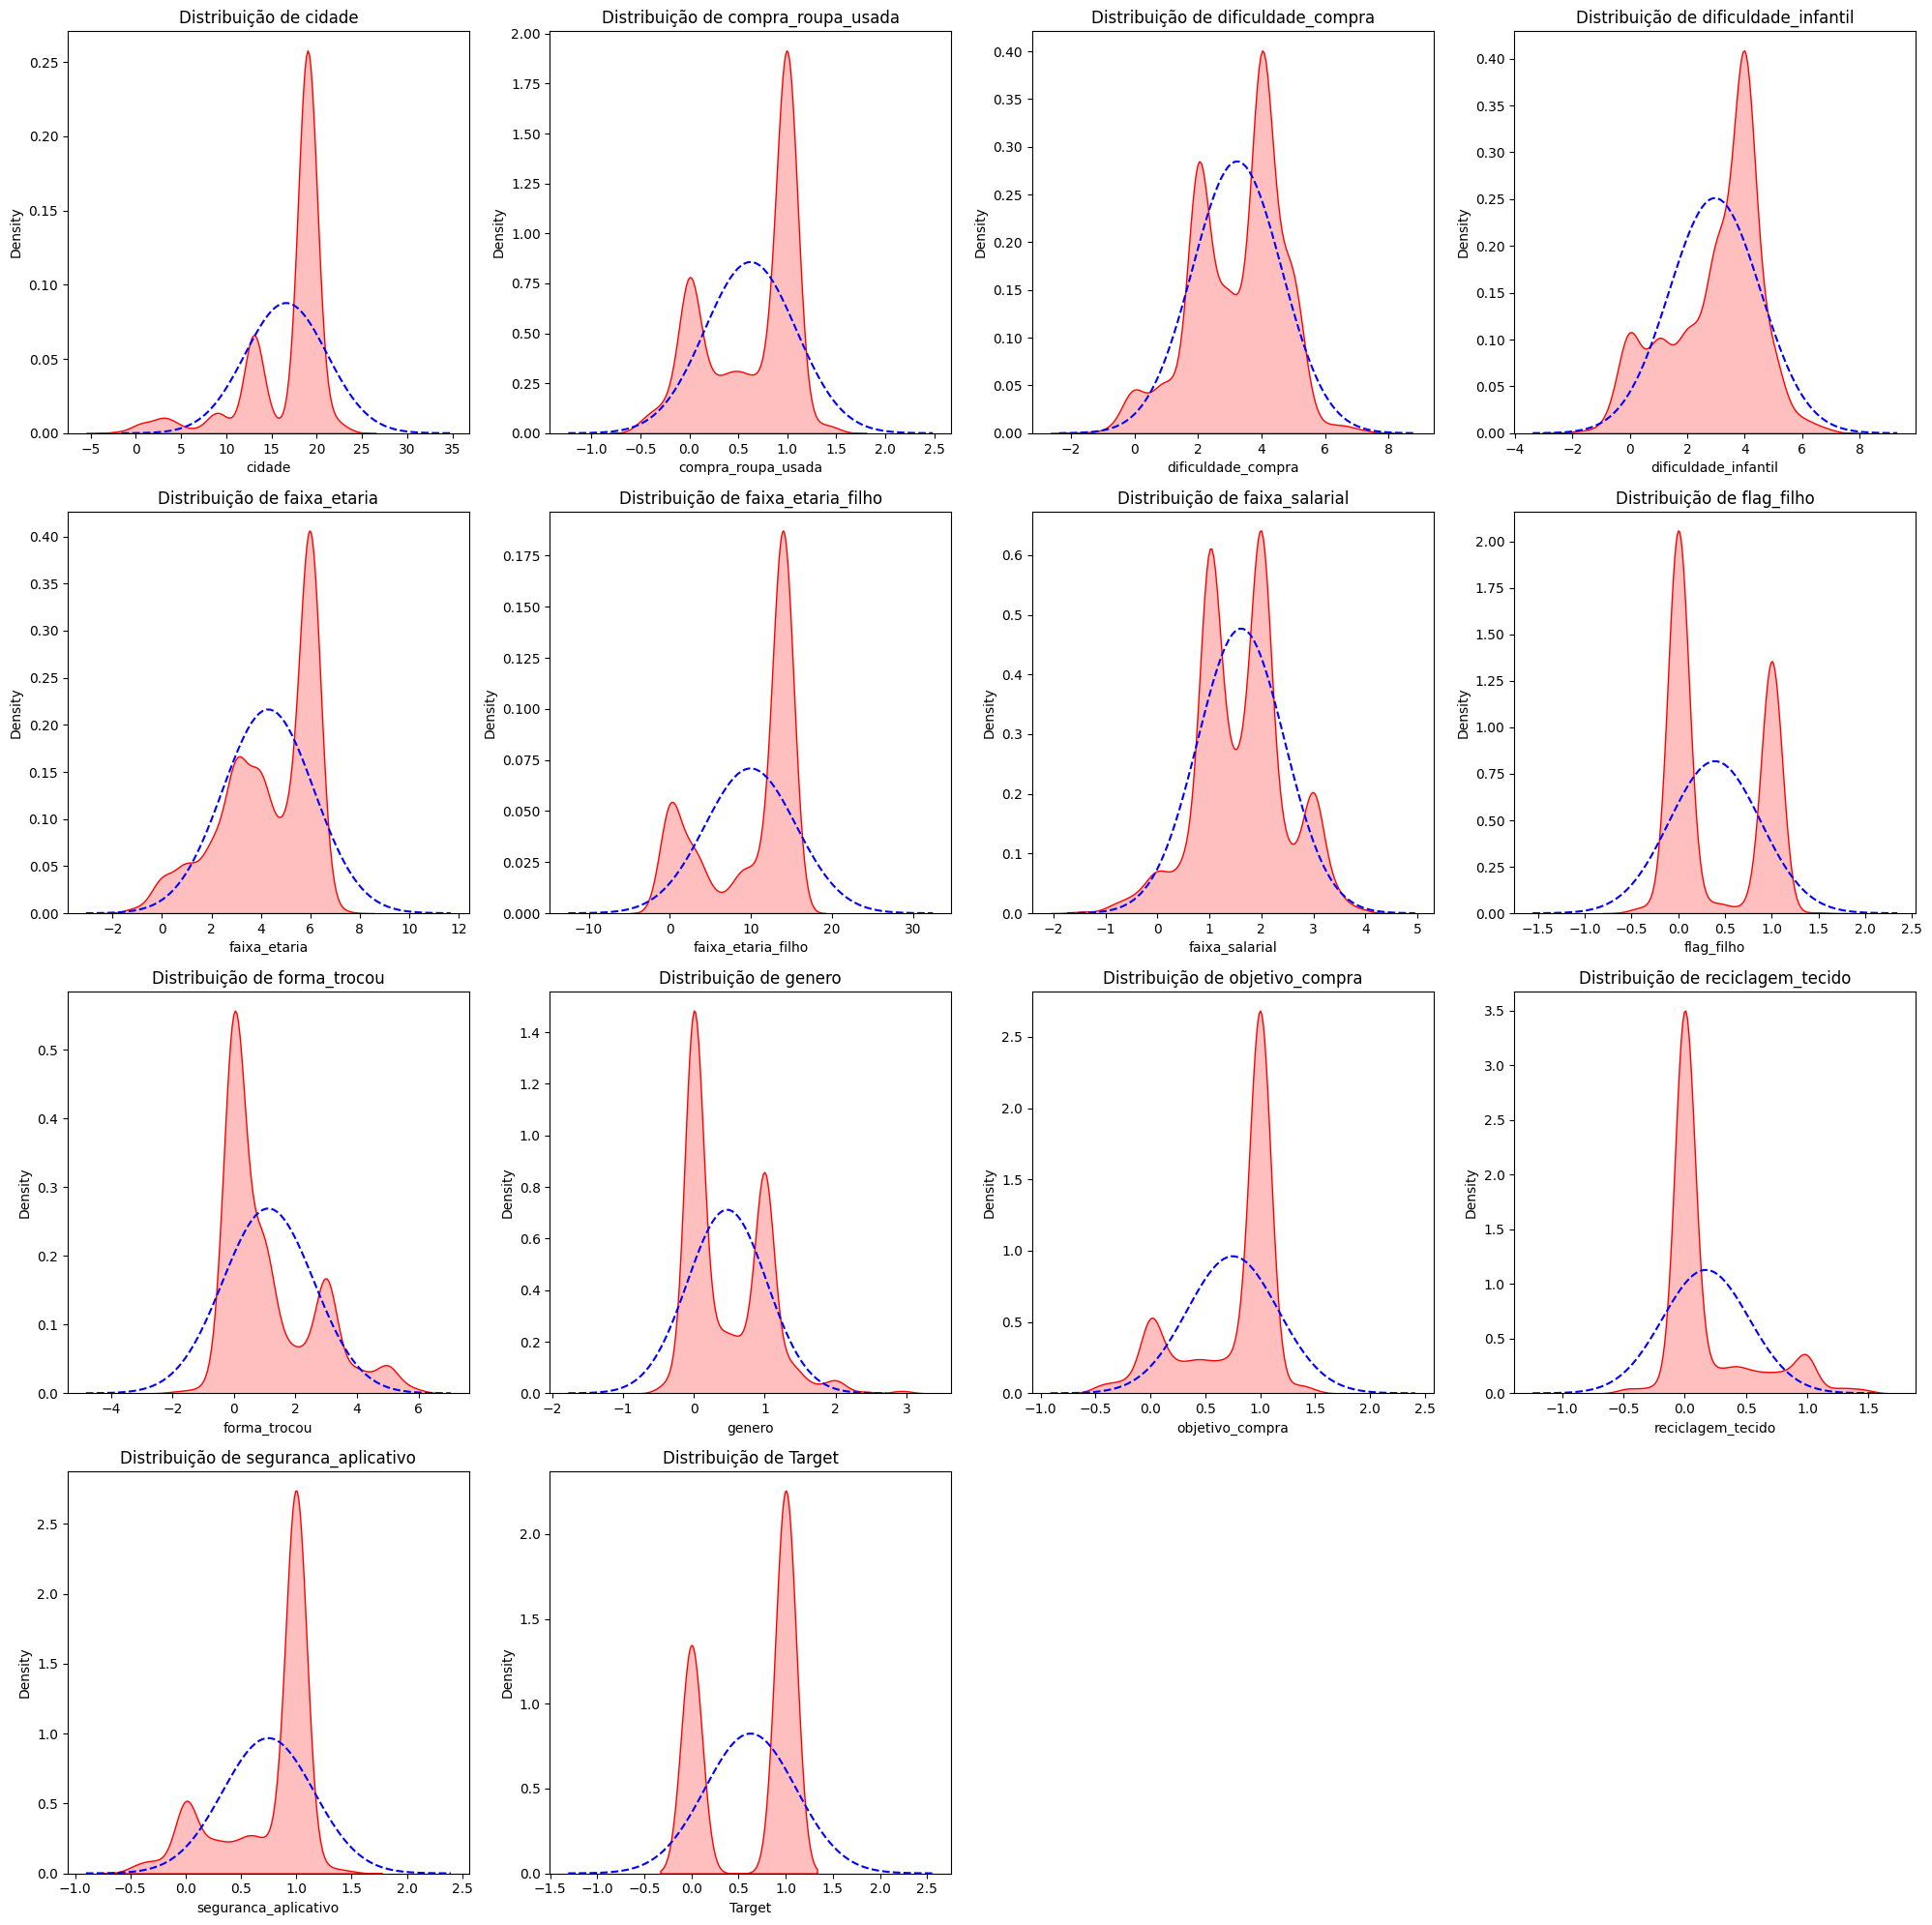

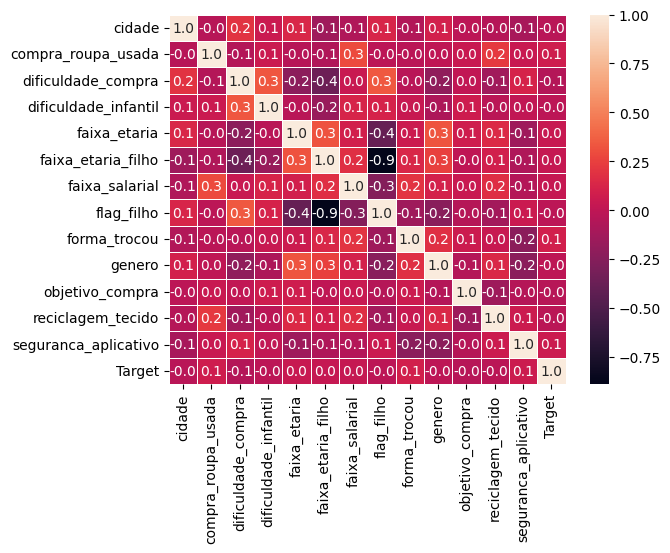

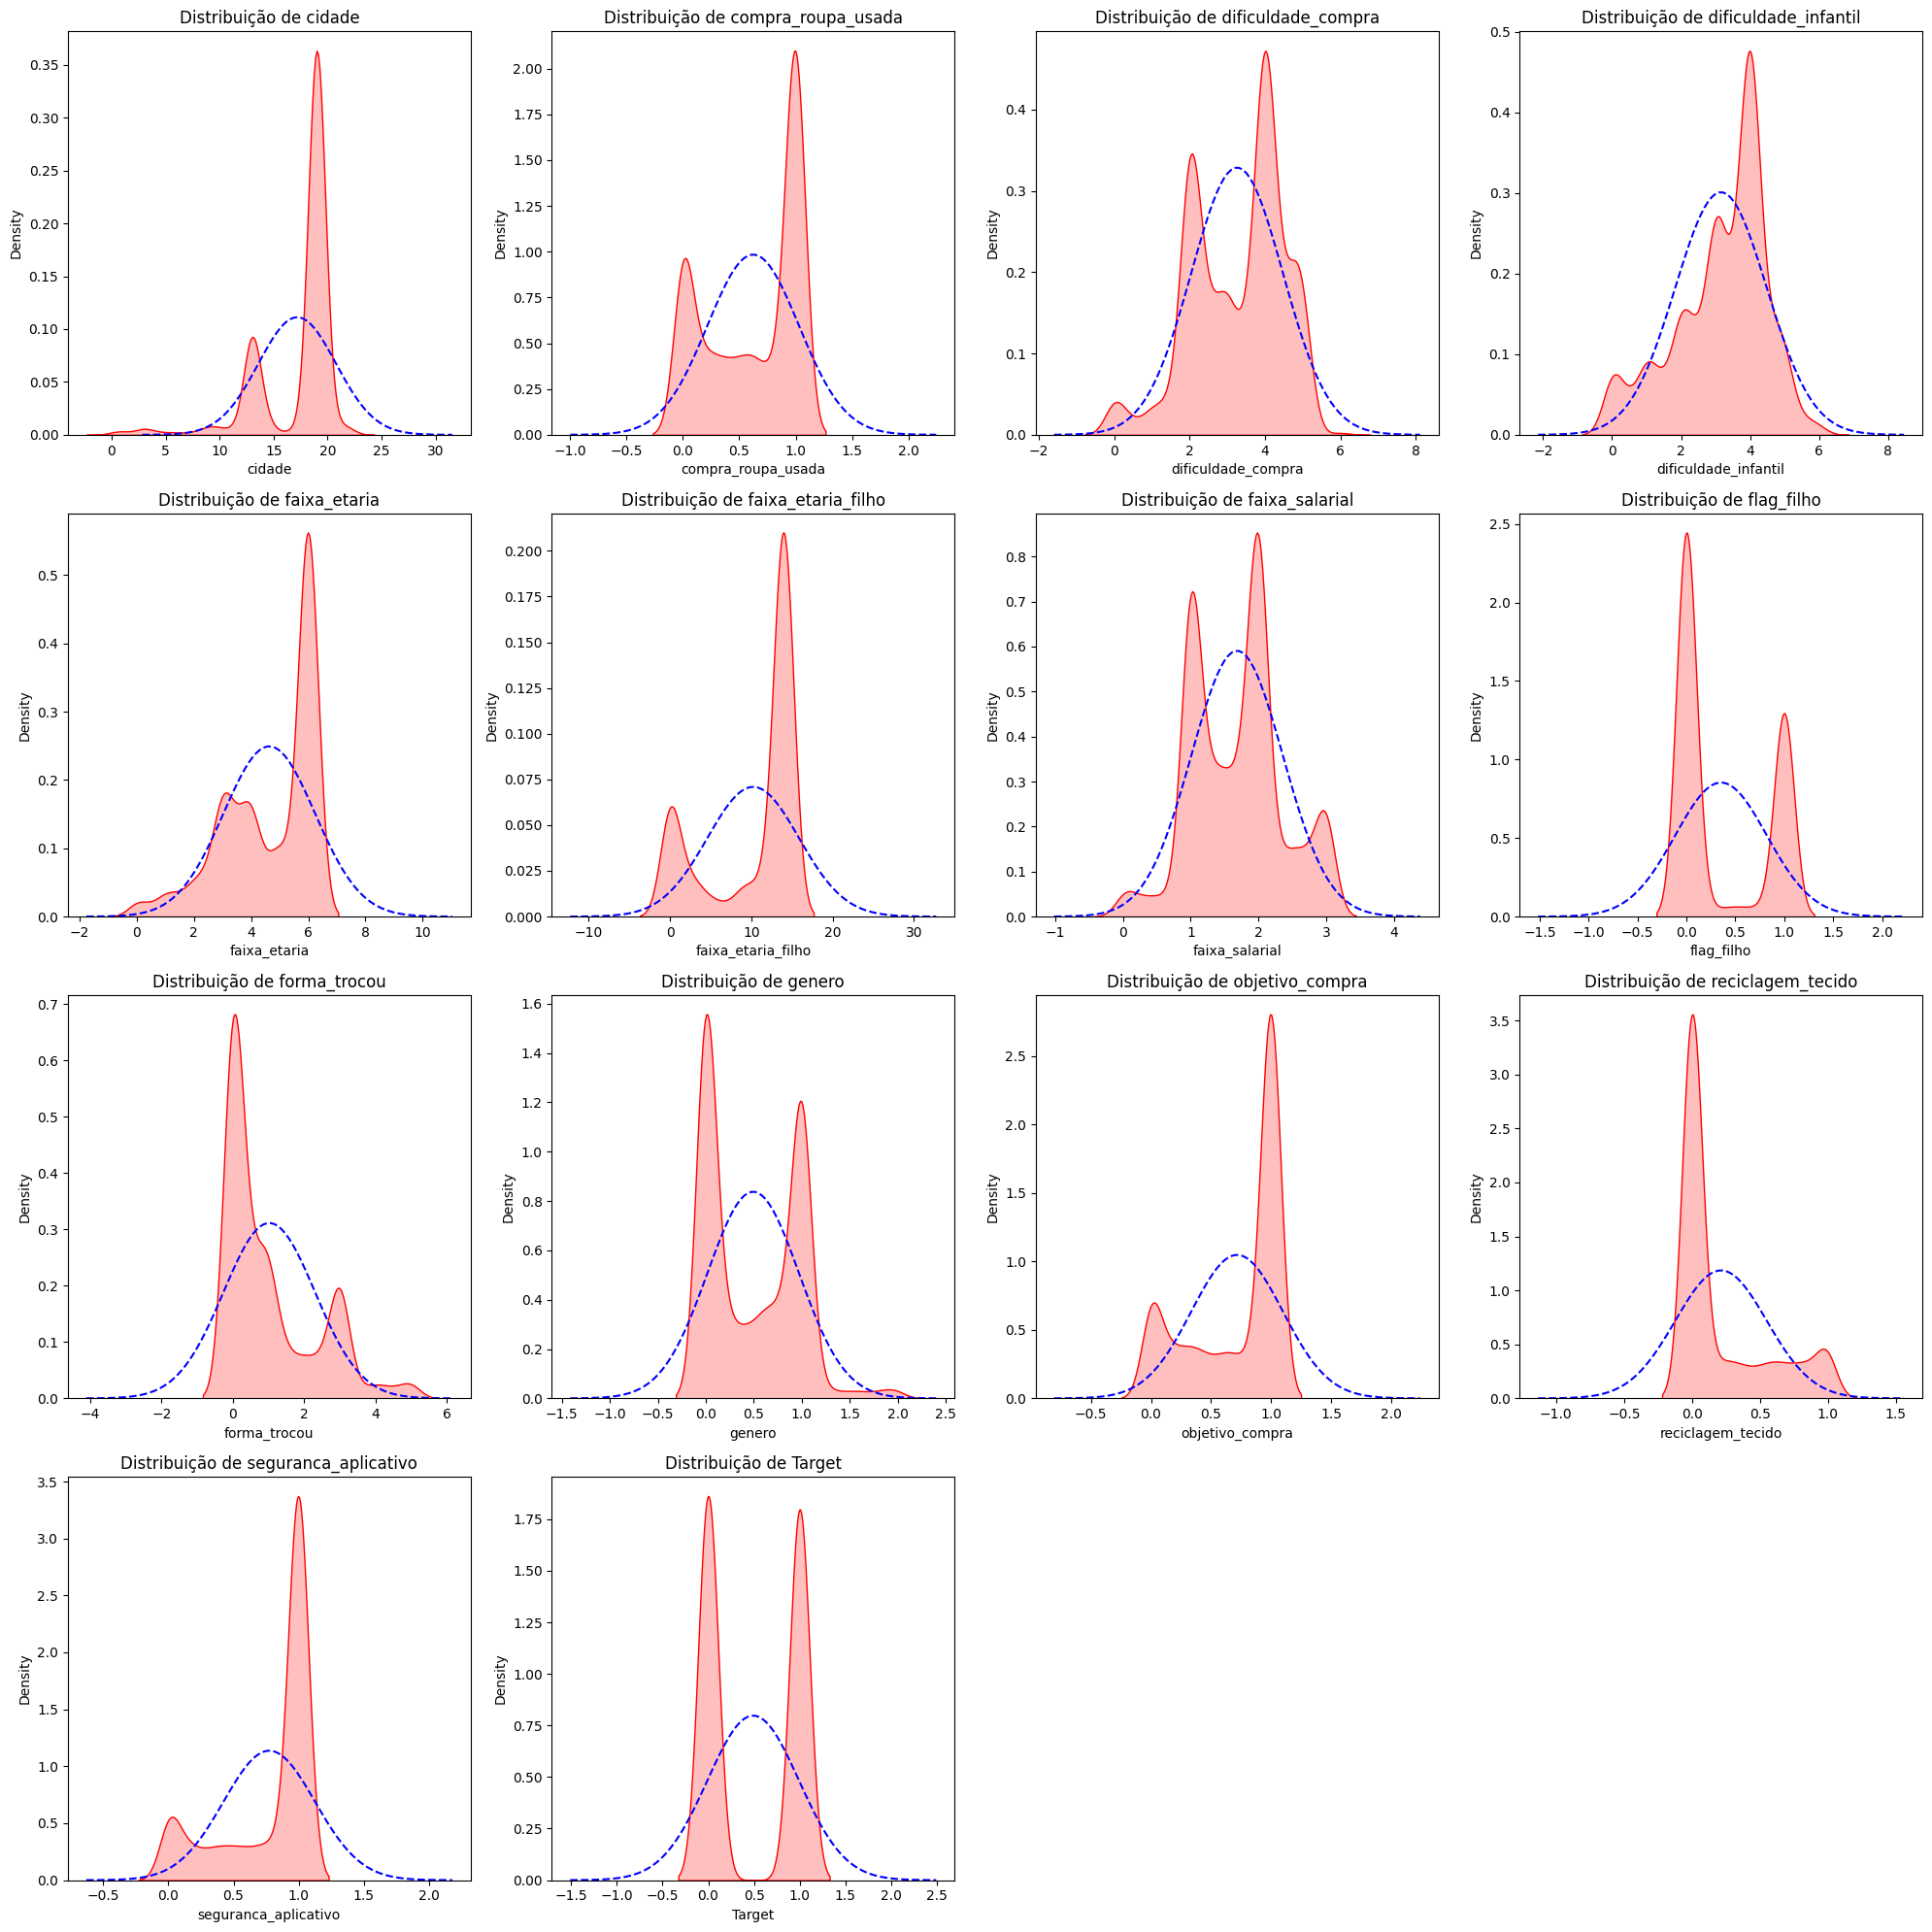

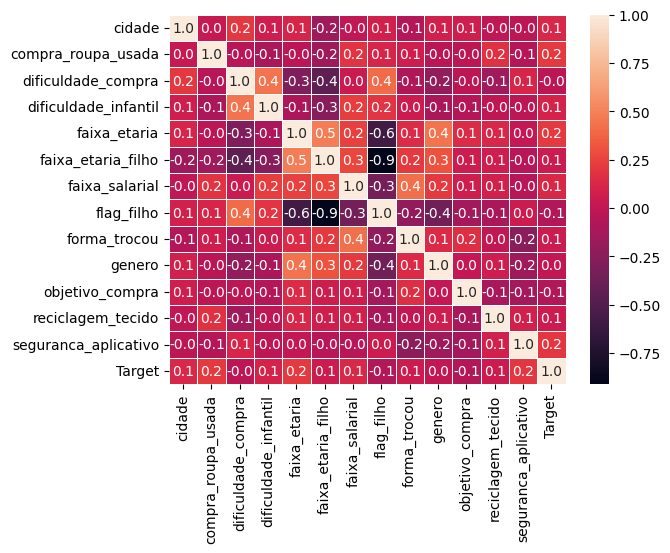

In [22]:
for i in melhores_modelos.keys():
    base = bases_armazenadas[melhores_modelos[i][1]]
    fig, axs = plt.subplots(int(np.ceil(len(base.columns) / 4)), 4, figsize=(20, 20))
    axs = axs.flatten()
    
    for i, col in enumerate(base.columns):
        sns.kdeplot(base[col], fill=True, color="red", ax=axs[i])
    
        mean = base[col].mean()
        std = base[col].std()
    
        x = np.linspace(mean - 4*std, mean + 4*std, 100)
        y = norm.pdf(x, mean, std)
    
        axs[i].plot(x, y, color='b', linestyle='--')
        axs[i].set_title(f'Distribuição de {col}')
    
    for j in range(len(base.columns), len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()
    
    correlation = base[base.columns.to_list()].corr()
    sns.heatmap(correlation, annot=True, fmt=".1f", linewidths=.6)
    plt.show()